In [3]:
%matplotlib notebook
import numpy as np
from numpy.linalg import norm as norm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import math as m
from scipy.special import hankel1 as hankel
from scipy.interpolate import interp1d

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt

folder = 'C:/Users/jabuk/Documents/jaderka/diplomka/images_jup/'

yellow='#ffb200'
red='#DD5544'
blue='#0284C0'

In [4]:
class Permeability():
    def __init__(self):
        f= open('gold_pcgrate.txt', 'r')
        contents=f.readlines()

        self.wavelength=[]
        self.epsilon=[]
        self.real=[]
        self.imag=[]

        for line in contents[:-1]:
            line_split=line.split('\t')
            if 0.3<float(line_split[0])<1.5:
                self.wavelength.append(float(line_split[0])/1e6)
                
                eps=(float(line_split[1])+1j*float(line_split[2]))**2
                self.epsilon.append(eps)
                self.real.append(np.real(eps))
                self.imag.append(np.imag(eps))
        
        k=3
        self.sreal=interp1d(self.wavelength, self.real, kind='linear')
        self.simag=interp1d(self.wavelength, self.imag, kind='linear')

    def eps(self, lm):
        return self.sreal(lm)+1j*self.simag(lm)
metal=Permeability()

In [5]:
def U(k, x):
    return U0*np.exp(1j*np.dot(np.real(k), x))

def Udiff(k, r, x):
    rr=norm(x-r)
    p=np.dot(x-r, np.array([1,0]))/rr #scalar product disabling SPP with k perpendicular to original SPP
    if rr==0:
        return 0.2
    return 0.2*U(k, r)*np.exp(1j*rr*norm(np.real(k)))*p*np.exp(-norm(np.imag(k))*rr)#/((rr+2.93e6)**0.5)

def Pattern(k, r, x):
    alpha = 3
    rr=norm(x-r)
    p=np.dot(x-r, np.array([1,0]))/rr #scalar product disabling SPP with k perpendicular to original SPP
    back = intensity(U(-k,x)+alpha* U(-k,r)*1j/4*hankel(0, beta*np.linalg.norm(x - r)))
    forward = intensity(U(k,x)+alpha* U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(x - r)))
    return back+forward


def intensity(u):
    return u*np.conjugate(u)

In [3]:
U0=1

k=np.array([(11755041.21345882+78217.09878973379j), 0]) #750
# k=np.array([(15604823.125390332-526208.287757275j), 0]) #600
# k=np.array([(14000259.1178857-236982.93413896085j), 0]) #650

beta=k[0]
print(2*m.pi/beta)

(5.344861850844878e-07-3.5564280874350315e-09j)


In [23]:
2.93*1e-7*1e3*1e6

292.99999999999994

In [15]:
px = 2.93*1e-7
# px = 2.93*1e-6
# X=np.arange(0,200*px, px)
# Y=np.arange(0,200*px, px)
# r=np.array([100,100])*px

X = np.arange(0,1000*px, px)
Y = np.arange(0,1000*px, px)
r = np.array([500,500])*px
alpha = 3


raw = np.zeros([len(Y),len(X)])

for i in range(len(Y)):
    for j in range(len(X)):
        x = X[j]
        y = Y[i]
#       raw[i,j]=intensity(U(k,np.array([x,y])))
#         raw[i,j] = intensity(U(k,np.array([x,y]))+alpha* U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r)))
        raw[i,j] = Pattern(k, r, np.array([x,y]))
    
#         raw[i,j] += U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r))
        
#         raw[i,j] = intensity(raw[i,j])
        





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


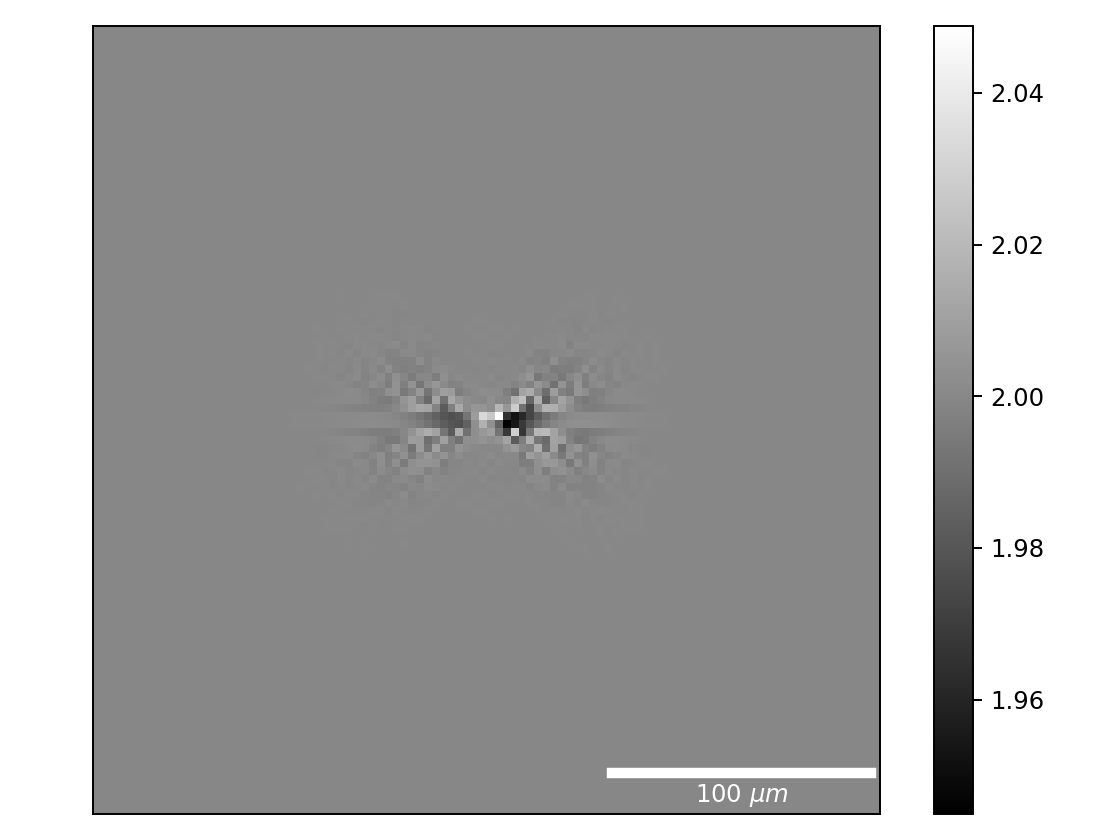

In [36]:
fig, ax = plt.subplots()

image_resized = resize(raw, (raw.shape[0] // 10, raw.shape[1] // 10), anti_aliasing=False)
px=2.93e-7

image_rescaled = rescale(raw, 0.1, anti_aliasing=False)


img = ax.imshow(image_rescaled)
plt.set_cmap('gray')
fig.colorbar(img)
# ax.set_title('Interference pattern', fontsize=16)



fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
           34*2.93/px/1e6/10, '100 $\mu m$', 'lower right', 
           pad=0.1,
           color='white',
           frameon=False,
           size_vertical=1,
           fontproperties=fontprops)

ax.add_artist(scalebar)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_visible(False)
    
plt.tight_layout()      
# fig.savefig(folder + 'hankel_interference_750.png', dpi = 300)
# ,clim=(0, 20)

In [19]:
px = 5*1e-8
X=np.arange(0,200*px, px)
Y=np.arange(0,200*px, px)

r=np.array([100,100])*px
alpha = 3


data=np.zeros([len(Y),len(X)])

for i in range(len(Y)):
    for j in range(len(X)):
        x=X[j]
        y=Y[i]
#         data[i,j]=intensity(U(k,np.array([x,y])))
#         data[i,j] = intensity(U(k,np.array([x,y]))+alpha* U(k,r)*1j/4*hankel(0, beta*np.linalg.norm(np.array([x, y]) - r)))
        data[i,j] = hankel(0, beta*np.linalg.norm(np.array([x, y]) - r))
        
#         data[i,j] = intensity(data[i,j])
        





C:\Users\Bukacek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


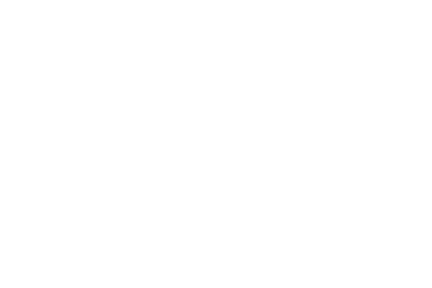

<IPython.core.display.Javascript object>


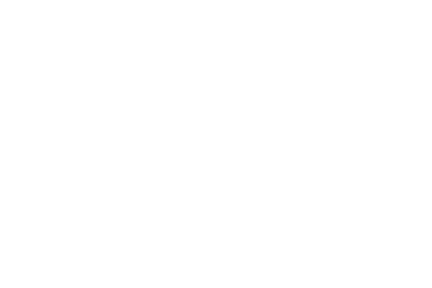

In [20]:
fig, ax = plt.subplots()
img = ax.imshow(data)
plt.set_cmap('gray')

fig.colorbar(img)
# ax.set_title('$\mathcal{R}\{H_0^{1}\}$', fontsize=16)



fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
           34*2.93/px/1e8, '1 $\mu m$', 'lower right', 
           pad=0.1,
           color='white',
           frameon=False,
           size_vertical=1,
           fontproperties=fontprops)

ax.add_artist(scalebar)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for tick in ax.get_xticklabels():
    tick.set_visible(False)
    
plt.tight_layout()      
# fig.savefig(folder + 'hankel_real.png', dpi = 300)
# ,clim=(0, 20)

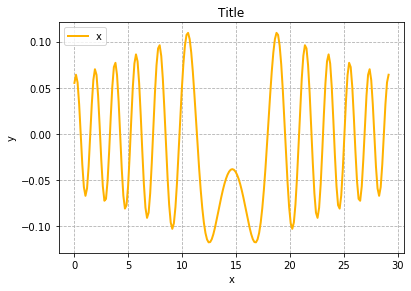

In [129]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.grid(linestyle='--')
axes.set_title('Title')
axes.set_xlabel('x')
axes.set_ylabel('y')

x = np.arange(1,10,0.2)
y = x**2 

name='test_01'
axes.plot(X*2.93e6,data[50,:], color=yellow, linewidth=2, label='x')
# axes.plot(x, x**3, color=blue, linewidth=2, label='y')
axes.legend(loc=2)
# fig.savefig('jupyter_plots/' + name + '.png', dpi=300)

In [12]:
R = 100e-9
ns = 1.33
np = metal.eps(750e-9)
print(np)

(-21.026305842105266+1.5468600000000001j)


In [11]:
4*m.pi*R**3*(np**2-ns**2)/(np**2+2*ns**2)

(1.2419094974924833e-20-2.1613525098262675e-23j)